# Final System Integration: AI Impersonation Detection (Transformer Edition)

## Overview
This notebook integrates the **Transformer-based Face Model** (Lavanya Project) and the **Transformer-based Background Model** (Manya Project) into a single pipeline.

### The Pipeline
1.  **Input**: Test Image.
2.  **Segmentation**: Separate the image into **Face Crop** and **Background Only**.
3.  **Step 1 (Face Check)**: 
    *   Pass Face Crop to Face Model.
    *   **Logic**: If Face is FAKE -> **STOP** (Verdict: FAKE).
4.  **Step 2 (Background Check)**:
    *   Only if Face is REAL, pass Background to Background Model.
    *   **Logic**: If Background is FAKE -> Verdict: FAKE.
    *   If Background is REAL -> Verdict: REAL.

---

In [1]:
# 1. Setup & Imports
import os
import shutil
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
from PIL import Image, ImageOps
from rembg import remove
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress TF warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

print("Libraries imported successfully.")

Libraries imported successfully.


## 2. Load Transformer Models
Ensure you have trained both models using `Transformers/Lavanya part face.ipynb` and `Transformers/Manya part bg.ipynb`.

In [2]:
# Paths to saved models
FACE_MODEL_PATH = r'C:\Users\Saket Rama\OneDrive\Desktop\PROJECTS\NUS\face_transformer.keras'
BG_MODEL_PATH = r'C:\Users\Saket Rama\OneDrive\Desktop\PROJECTS\NUS\bg_transformer.keras'

print("Loading Transformer models... (This may take a minute)")

try:
    face_model = load_model(FACE_MODEL_PATH)
    print("Face Model Loaded.")
except Exception as e:
    print(f"Error loading Face Model: {e}")
    print("Did you run 'Lavanya part face.ipynb' to train it yet?")

try:
    bg_model = load_model(BG_MODEL_PATH)
    print("Background Model Loaded.")
except Exception as e:
    print(f"Error loading Background Model: {e}")

Loading Transformer models... (This may take a minute)
Face Model Loaded.
Background Model Loaded.


## 3. Helper Functions (Segmentation & Preprocessing)

In [3]:
def segment_image(image_path):
    """
    Splits an image into Face Crop and Background Only using rembg.
    Returns: (face_crop_pil, bg_only_pil)
    """
    original_image = Image.open(image_path).convert("RGB")
    
    # 1. Get Foreground (Face/Person)
    fg_with_alpha = remove(original_image.convert("RGBA"))
    
    # Create Face Crop
    alpha = fg_with_alpha.getchannel('A')
    bbox = alpha.getbbox()
    
    if bbox:
        face_crop = original_image.crop(bbox)
    else:
        face_crop = original_image
        
    # 2. Get Background Only
    inverted_alpha = ImageOps.invert(alpha)
    bg_only = original_image.copy()
    bg_only.putalpha(inverted_alpha)
    bg_only = bg_only.convert("RGB")
    
    return face_crop, bg_only

def preprocess_image(pil_img):
    """
    MobileNetV3 expects: (224, 224, 3) and specific preprocessing (-1 to 1).
    """
    img = pil_img.resize((224, 224))
    img_array = img_to_array(img)
    
    # Use the standard MobileNetV3 preprocessing function
    # This handles the scaling correctly (usually to -1...1)
    img_array = preprocess_input(img_array)
    
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

## 4. The Pipeline Logic

In [4]:
def predict_pipeline(image_path):
    # 1. Segmentation
    face_img, bg_img = segment_image(image_path)
    
    # 2. Face Check
    face_input = preprocess_image(face_img)
    # Model output shape is (1, 2) [prob_fake, prob_real] usually for SparseCategorical
    # Or (1, 1) for Binary. Let's assume SparseCategorical (2 neurons) based on training code.
    face_preds = face_model.predict(face_input, verbose=0)
    
    # Handle output shape (Softmax vs Sigmoid)
    if face_preds.shape[-1] == 2:
        face_score = face_preds[0][1] # Probability of Class 1 (REAL)
    else:
        face_score = face_preds[0][0]
    
    # LOGIC: FAKE=0, REAL=1
    if face_score < 0.5:
        return "FAKE", face_score, 0.0, face_img, bg_img
    
    # 3. Background Check (Only if Face is Real)
    bg_input = preprocess_image(bg_img)
    bg_preds = bg_model.predict(bg_input, verbose=0)
    
    if bg_preds.shape[-1] == 2:
        bg_score = bg_preds[0][1]
    else:
        bg_score = bg_preds[0][0]
    
    # Final Verdict
    if bg_score < 0.5:
        final_verdict = "FAKE"
    else:
        final_verdict = "REAL"
        
    return final_verdict, face_score, bg_score, face_img, bg_img

## 5. System Evaluation & Comparison

Evaluating system on: C:\Users\Saket Rama\OneDrive\Desktop\PROJECTS\NUS\dataset_split\test
Processing class: fake...
Processing class: real...

Transformer System Accuracy: 0.8093

--- Detailed Classification Report (F1 Score) ---
              precision    recall  f1-score   support

        FAKE       0.75      0.93      0.83      1505
        REAL       0.91      0.69      0.78      1500

    accuracy                           0.81      3005
   macro avg       0.83      0.81      0.81      3005
weighted avg       0.83      0.81      0.81      3005



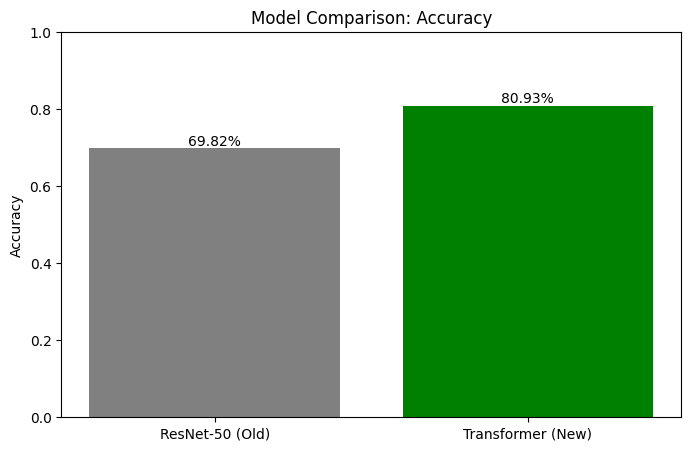

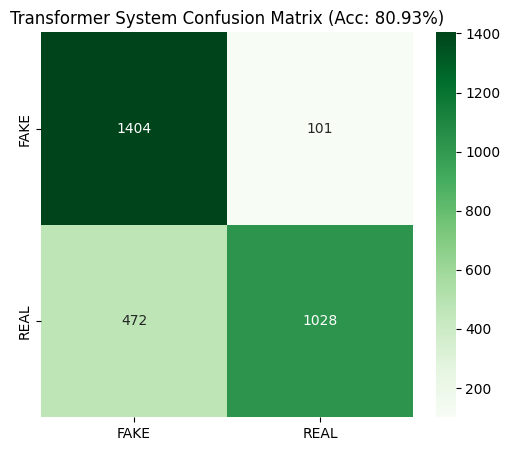

In [5]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def evaluate_system(test_dir):
    print(f"Evaluating system on: {test_dir}")
    y_true = []
    y_pred = []
    class_map = {'fake': 0, 'real': 1, 'FAKE': 0, 'REAL': 1}
    for label_name in os.listdir(test_dir):
        label_dir = os.path.join(test_dir, label_name)
        if not os.path.isdir(label_dir):
            continue
        true_label = class_map.get(label_name.lower(), -1)
        if true_label == -1: continue
        print(f"Processing class: {label_name}...")
        for filename in os.listdir(label_dir):
            img_path = os.path.join(label_dir, filename)
            try:
                verdict, _, _, _, _ = predict_pipeline(img_path)
                pred_label = 1 if verdict == "REAL" else 0
                y_true.append(true_label)
                y_pred.append(pred_label)
            except Exception as e:
                pass
    # Metrics
    acc = accuracy_score(y_true, y_pred)
    print(f"\nTransformer System Accuracy: {acc:.4f}")
    # --- ADDED: F1 Score Report ---
    print("\n--- Detailed Classification Report (F1 Score) ---")
    print(classification_report(y_true, y_pred, target_names=['FAKE', 'REAL']))
    
    # --- COMPARISON VISUALIZATION ---
    resnet_acc = 0.6982 # Hardcoded from previous run
    
    models = ['ResNet-50 (Old)', 'Transformer (New)']
    accuracies = [resnet_acc, acc]
    
    plt.figure(figsize=(8, 5))
    bars = plt.bar(models, accuracies, color=['gray', 'green'])
    plt.ylim(0, 1.0)
    plt.title('Model Comparison: Accuracy')
    plt.ylabel('Accuracy')
    
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height, 
                 f'{height:.2%}', ha='center', va='bottom')
    plt.show()
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=['FAKE', 'REAL'], yticklabels=['FAKE', 'REAL'])
    plt.title(f'Transformer System Confusion Matrix (Acc: {acc:.2%})')
    plt.show()

# Run Evaluation
TEST_DIR = r'C:\Users\Saket Rama\OneDrive\Desktop\PROJECTS\NUS\dataset_split\test'
if os.path.exists(TEST_DIR):
    evaluate_system(TEST_DIR)
else:
    print("Test directory not found.")